In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

from theano import tensor as tt
from scipy import stats

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 15 - The SIMPLE model of memory

## 15.1 The SIMPLE model
Brown, Neath, and Chater (2007) proposed the SIMPLE (Scale-Invariant Memory, Perception, and LEarning) model, which, among various applications, has been applied to the basic memory phenomenon of free recall.

$$ c_x \sim \text{Uniform}(0,100)$$
$$ s_x \sim \text{Uniform}(0,100)$$
$$ t_x \sim \text{Uniform}(0,1) $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

In [2]:
y = pd.read_csv('data/k_M.txt', ',', header=None)
n = np.array([1440, 1280, 1520, 1520, 1200, 1280])
listlength = np.array([10, 15, 20, 20, 30, 40])
lagall = np.array([2, 2, 2, 1, 1, 1])
offset = np.array([15, 20, 25, 10, 15, 20])
dsets = 6
m = np.zeros(np.shape(y))
for i in range(dsets):
    m[i, 0:listlength[i]] = offset[i] + \
        np.arange((listlength[i]) * lagall[i], 0, -lagall[i])
pc = pd.read_csv('data/pc_M.txt', ',', header=None)
pcmat = np.asarray(pc).T

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 1,523.2:  17%|█▋        | 34094/200000 [01:22<06:42, 412.24it/s]
Convergence archived at 34100
Interrupted at 34,099 [17%]: Average Loss = 29,965
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tx_interval__, sx_interval__, cx_interval__]
100%|██████████| 2000/2000 [11:28<00:00,  3.05it/s]


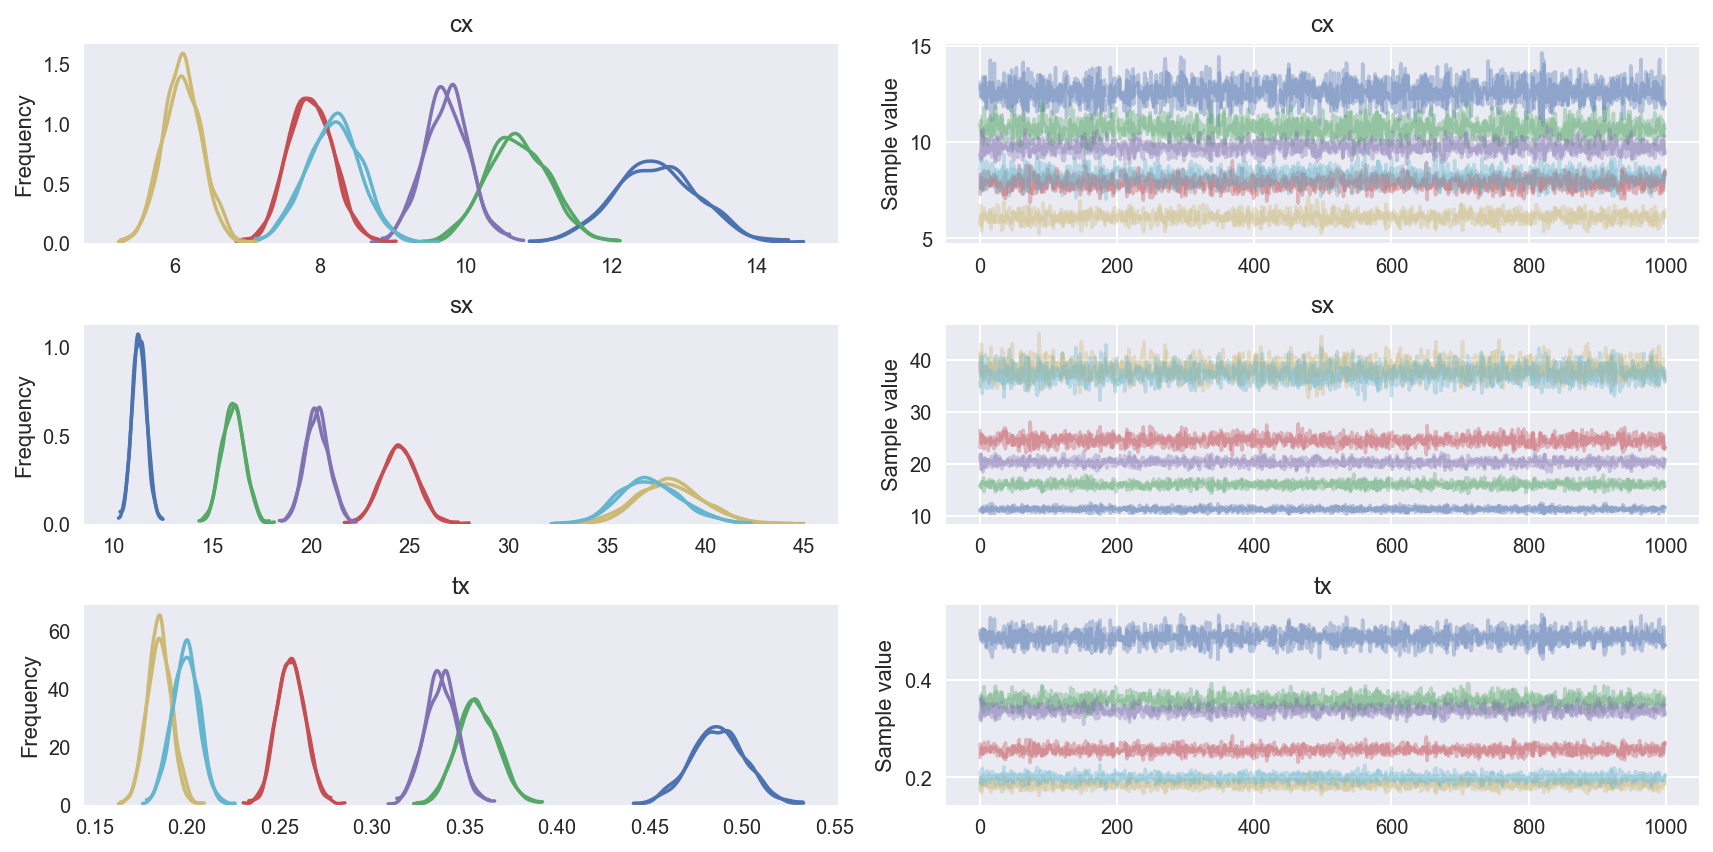

In [3]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2 == 0] = 1e-5  # to avoid NaN in ADVI
nmat = np.repeat(n[:, np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:, :, np.newaxis], nitem, axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat > 0)

with pm.Model() as simple1:
    cx = pm.Uniform('cx', lower=0, upper=100, shape=dsets,
                    testval=np.ones(dsets) * 20)
    sx = pm.Uniform('sx', lower=0, upper=100, shape=dsets)
    tx = pm.Uniform('tx', lower=0, upper=1, shape=dsets)

    # Similarities
    eta = tt.exp(-cx[:, np.newaxis, np.newaxis] *
                 abs(tt.log(mmat1) - tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2),
                                  nitem), (dsets, nitem, nitem))

    # Discriminabilities
    disc = eta / etasum

    # Response Probabilities
    resp = 1 / (1 + tt.exp(-sx[:, np.newaxis, np.newaxis]
                           * (disc - tx[:, np.newaxis, np.newaxis])))

    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta = 1 - tt.prod(1 - resp, axis=2)

    yobs = pm.Binomial('yobs', p=theta[mask],
                       n=nmat[mask], observed=ymat[mask])
    trace = pm.sample(1000, tune=1000, init='advi+adapt_diag')

pm.traceplot(trace, varnames=['cx', 'sx', 'tx']);

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 2,392.4:  14%|█▎        | 27480/200000 [00:36<03:57, 725.26it/s]  
Convergence archived at 27500
Interrupted at 27,499 [13%]: Average Loss = 75,637
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tx_interval__, sx_interval__, cx_interval__]
100%|██████████| 2000/2000 [05:30<00:00,  6.53it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


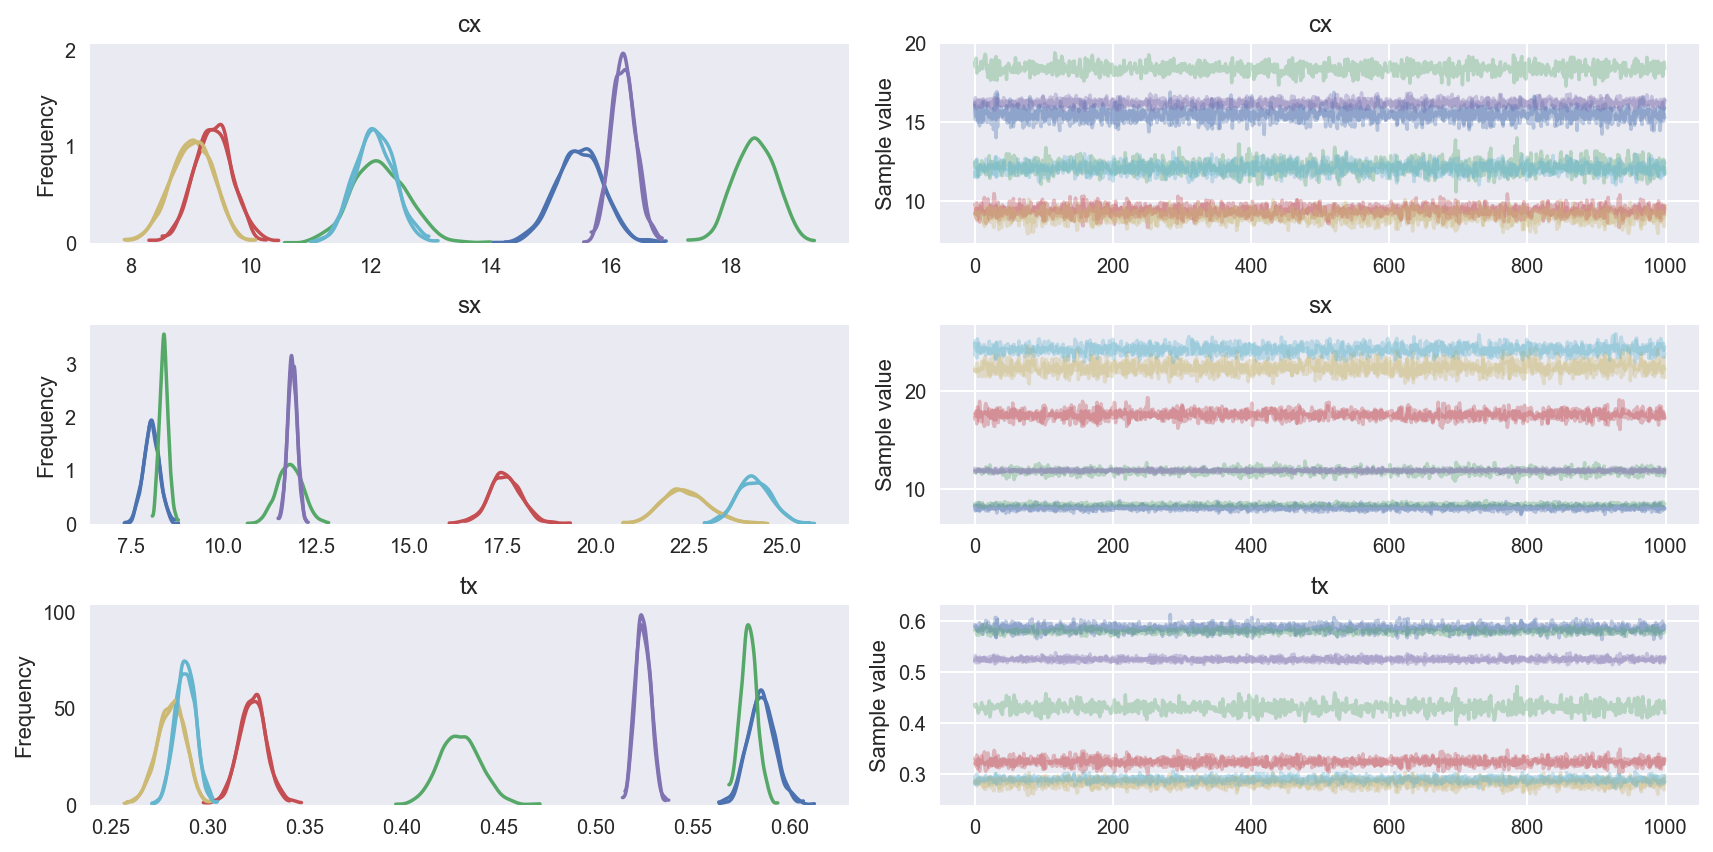

In [4]:
ymat = np.asarray(y).T
mmat = m.T

with pm.Model() as simple1:
    cx = pm.Uniform('cx', lower=0, upper=100, shape=dsets,
                    testval=np.ones(dsets) * 20)
    sx = pm.Uniform('sx', lower=0, upper=100, shape=dsets)
    tx = pm.Uniform('tx', lower=0, upper=1, shape=dsets)

    yobs = []
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x], ] * sz).T
        m2 = np.array([mmat[0:sz, x], ] * sz)

        eta = tt.exp(-cx[x] * abs(tt.log(m1) - tt.log(m2)))
        etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + tt.exp(-sx[x] * (disc - tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, .999)
        # theta=1-tt.prod(1-resp,axis=1)

        yobs.append([pm.Binomial("yobs_%x" % x, 
                                 p=theta, n=n[x], observed=ymat[0:sz, x])])

    trace = pm.sample(1000, tune=1000, init='advi+adapt_diag')

pm.traceplot(trace, varnames=['cx', 'sx', 'tx']);

The above two model does the same thing, but surprising using list compression is actually faster.

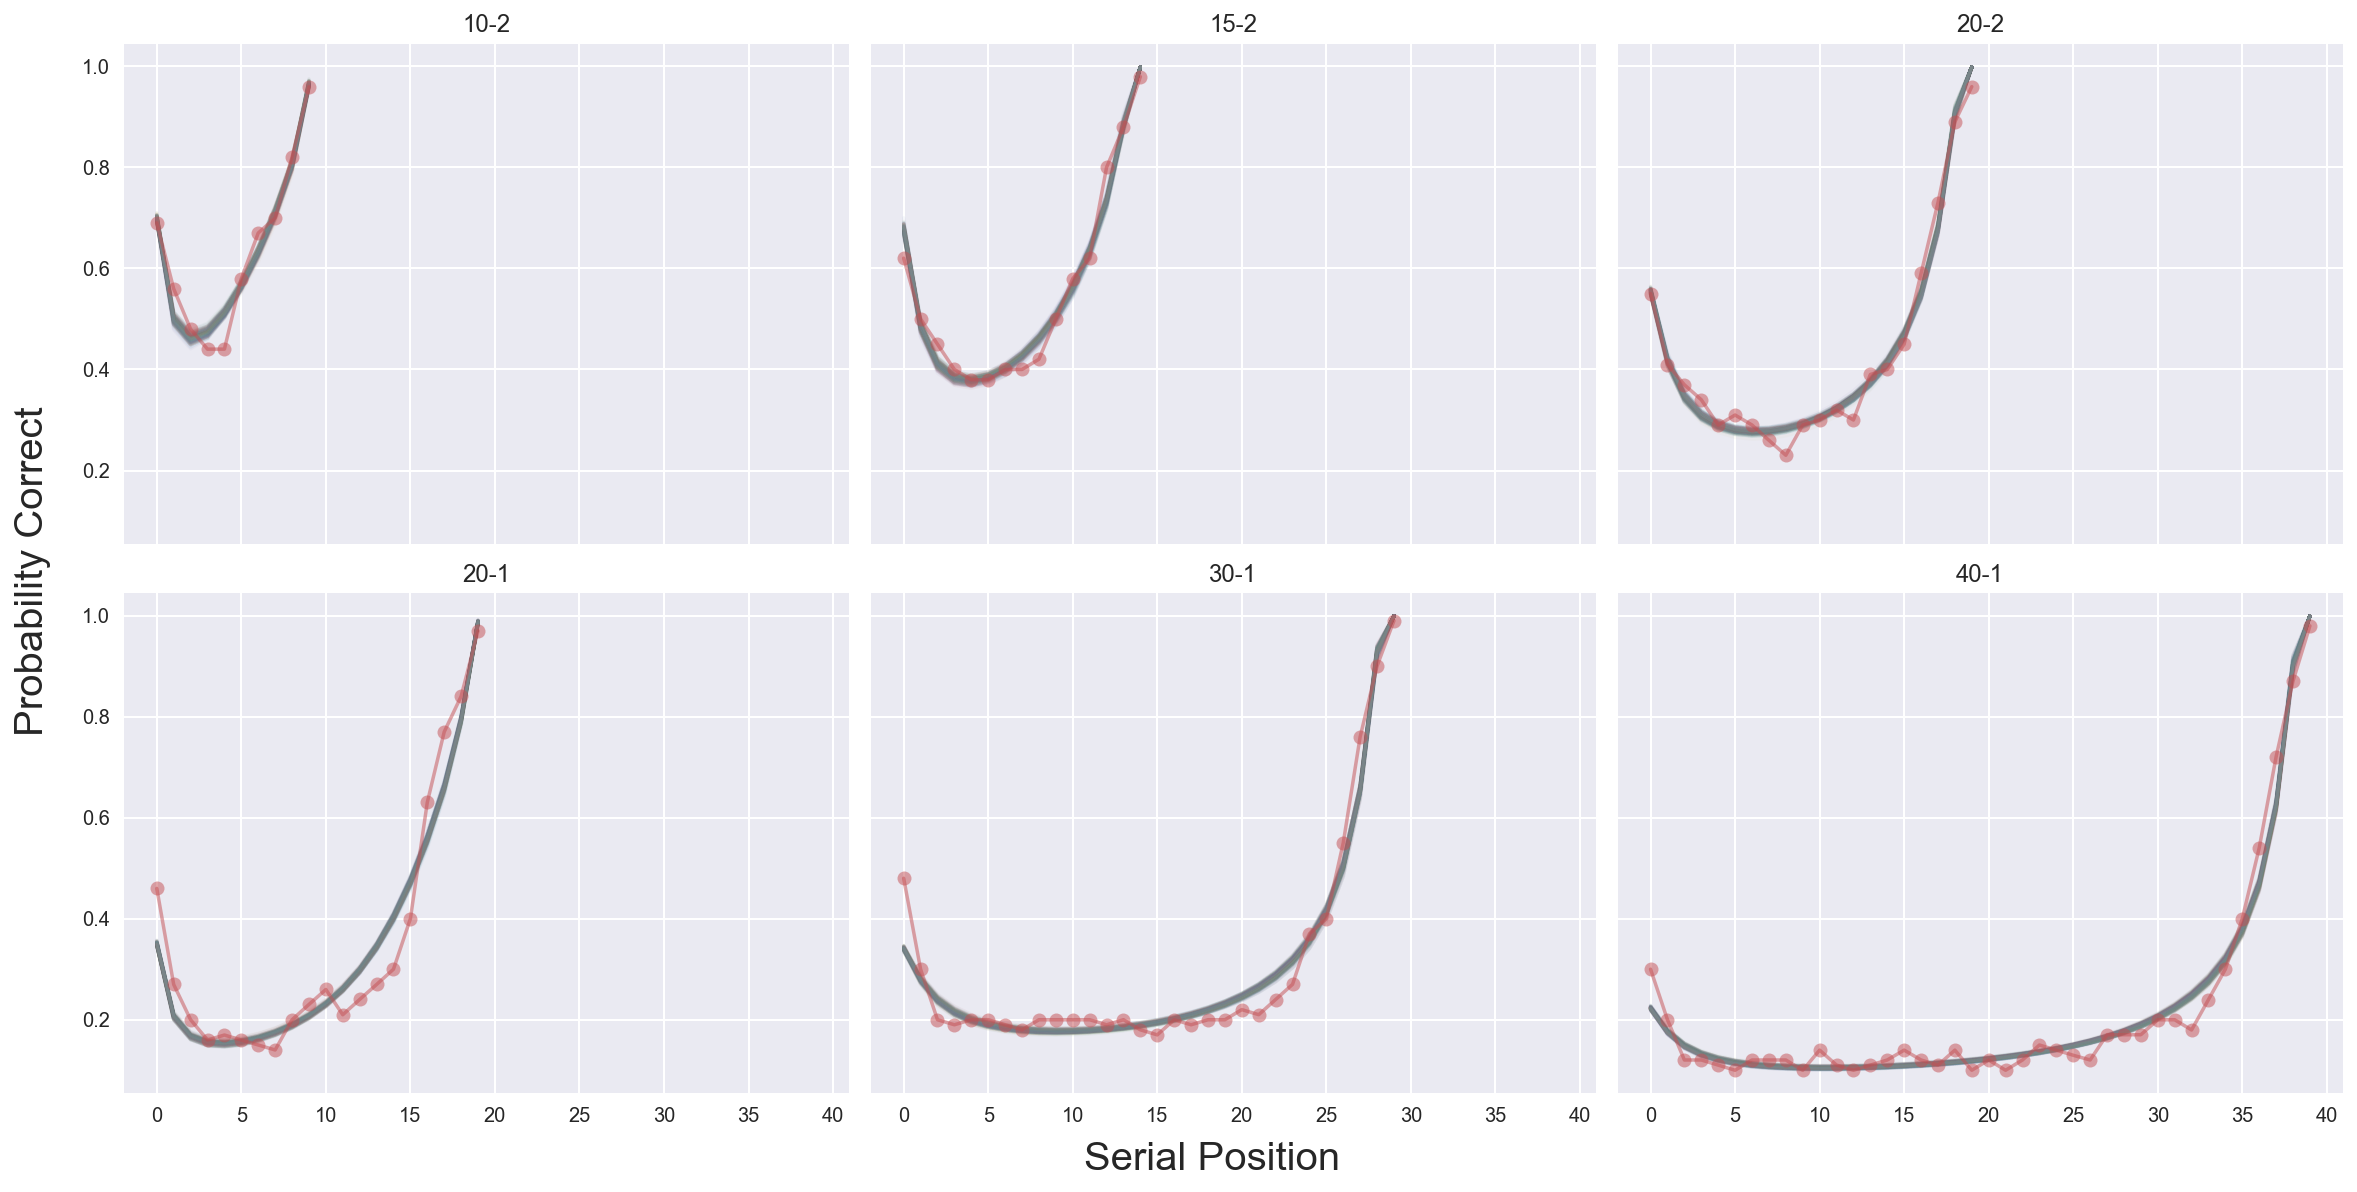

In [5]:
ymat = np.asarray(y).T
mmat = m.T

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
gs = axes.flatten()
fig.text(0.5, -0.02, 'Serial Position', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct',
         va='center', rotation='vertical', fontsize=20)

burnin = 0
totalsamp = 1000
ppcsamples = 200

for ip in range(dsets):
    ax = gs[ip]
    ay = ymat[:, ip] / n[ip]  # pcmat[:,ip]

    cxt = trace['cx'][:, ip]
    sxt = trace['sx'][:, ip]
    txt = trace['tx'][:, ip]

    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip], ] * sz).T
    m2 = np.array([mmat[0:sz, ip], ] * sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):

        eta = np.exp(-cxt[ips] * abs(np.log(m1) - np.log(m2)))
        etasum = np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + np.exp(-sxt[ips] * (disc - txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), .999)
        ax.plot(theta, alpha=.05)

    ax.plot(ay[ay != 0], marker='o', alpha=.5)
    ax.set_title(str(listlength[ip]) + '-' + str(lagall[ip]))

plt.tight_layout();

## 15.2 A hierarchical extension of SIMPLE


$$ c \sim \text{Uniform}(0,100)$$
$$ s \sim \text{Uniform}(0,100)$$
$$ a_{1} \sim \text{Uniform}(-1,0) $$
$$ a_{2} \sim \text{Uniform}(0,1) $$
$$ t_x = a_{1}W_x + a_{2} $$  
$$ \eta_{ijx} = \text{exp}(-\,c_x \,\lvert \text{log} T_{ix}\,-\,\text{log} T_{jx}\rvert)$$  
$$ d_{ijx} = \frac{\eta_{ijx}} {\sum_{k}\eta_{ikx}}$$  
$$ r_{ijx} = \frac{1} {1\,+\,\text{exp}(-\,s_{x}(d_{ijx}\,-\,t_{x}))}$$  
$$ \theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$$
$$ y_{ix} \sim \text{Binomial}(\theta_{ix},\eta_{x})$$

Model correction on SIMPLE model could be done by replacing $\theta_{ix} = \text{min}(1,\sum_{k}r_{ikx})$ with $\theta_{ix} = 1\,-\,\prod_{k}(1-r_{ikx})$ (see Box 15.2 on page 200)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 17,325:   5%|▌         | 10482/200000 [00:25<07:30, 420.60it/s]   
Convergence archived at 10500
Interrupted at 10,499 [5%]: Average Loss = 73,148
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2_interval__, a1_interval__, sx_interval__, cx_interval__]
100%|██████████| 2000/2000 [03:51<00:00,  8.64it/s]
The number of effective samples is smaller than 25% for some parameters.


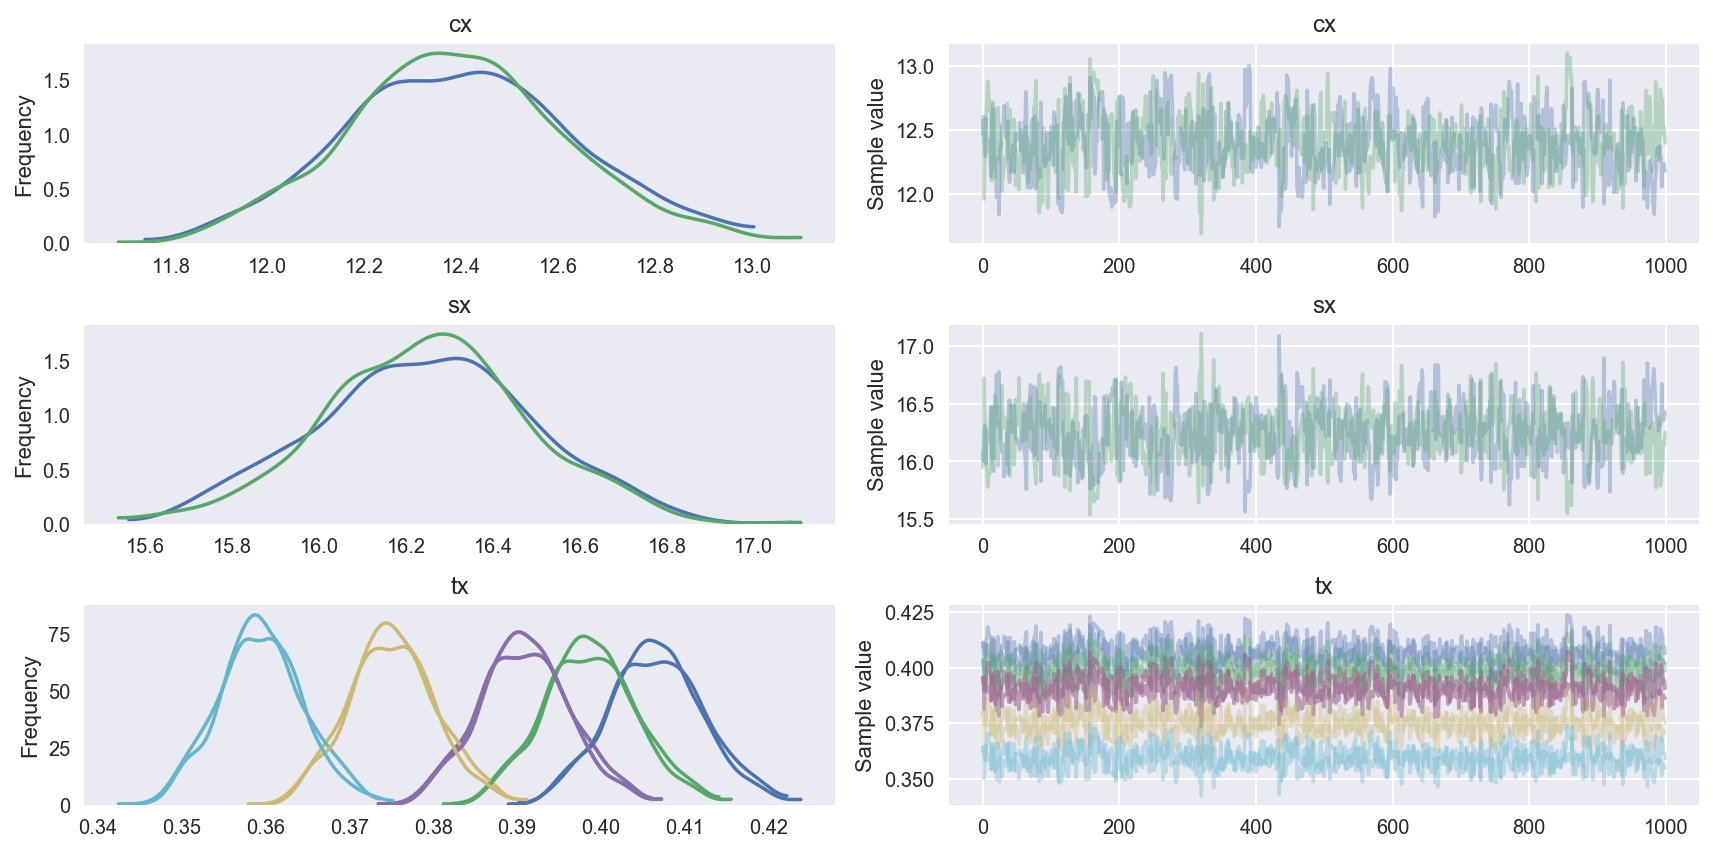

In [6]:
ymat = np.asarray(y)
nitem = m.shape[1]
m2 = m
m2[m2 == 0] = 1e-5  # to avoid NaN in ADVI
nmat = np.repeat(n[:, np.newaxis], nitem, axis=1)
mmat1 = np.repeat(m2[:, :, np.newaxis], nitem, axis=2)
mmat2 = np.transpose(mmat1, (0, 2, 1))
mask = np.where(ymat > 0)
W = listlength

with pm.Model() as simple2:
    cx = pm.Uniform('cx', lower=0, upper=100, testval=21)
    sx = pm.Uniform('sx', lower=0, upper=100, testval=10)
    a1 = pm.Uniform('a1', lower=-1, upper=0, testval=-.002)
    a2 = pm.Uniform('a2', lower=0, upper=1, testval=.64)
    tx = pm.Deterministic('tx', a1 * W + a2)

    # Similarities
    eta = tt.exp(-cx * abs(tt.log(mmat1) - tt.log(mmat2)))
    etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=2),
                                  nitem), (dsets, nitem, nitem))

    # Discriminabilities
    disc = eta / etasum

    # Response Probabilities
    resp = 1 / (1 + tt.exp(-sx * (disc - tx[:, np.newaxis, np.newaxis])))

    # Free Recall Overall Response Probability
    # theta = tt.clip(tt.sum(resp, axis=2), 0., .999)
    theta = 1 - tt.prod(1 - resp, axis=2)

    yobs = pm.Binomial('yobs', p=theta[mask],
                       n=nmat[mask], observed=ymat[mask])
    trace2_ = pm.sample(1000, tune=1000, init='advi+adapt_diag')

pm.traceplot(trace2_, varnames=['cx', 'sx', 'tx']);

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 31,211:   6%|▌         | 11175/200000 [00:15<07:50, 401.69it/s]   
Convergence archived at 11200
Interrupted at 11,199 [5%]: Average Loss = 1.276e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2_interval__, a1_interval__, sx_interval__, cx_interval__]
100%|██████████| 2000/2000 [01:26<00:00, 23.21it/s]


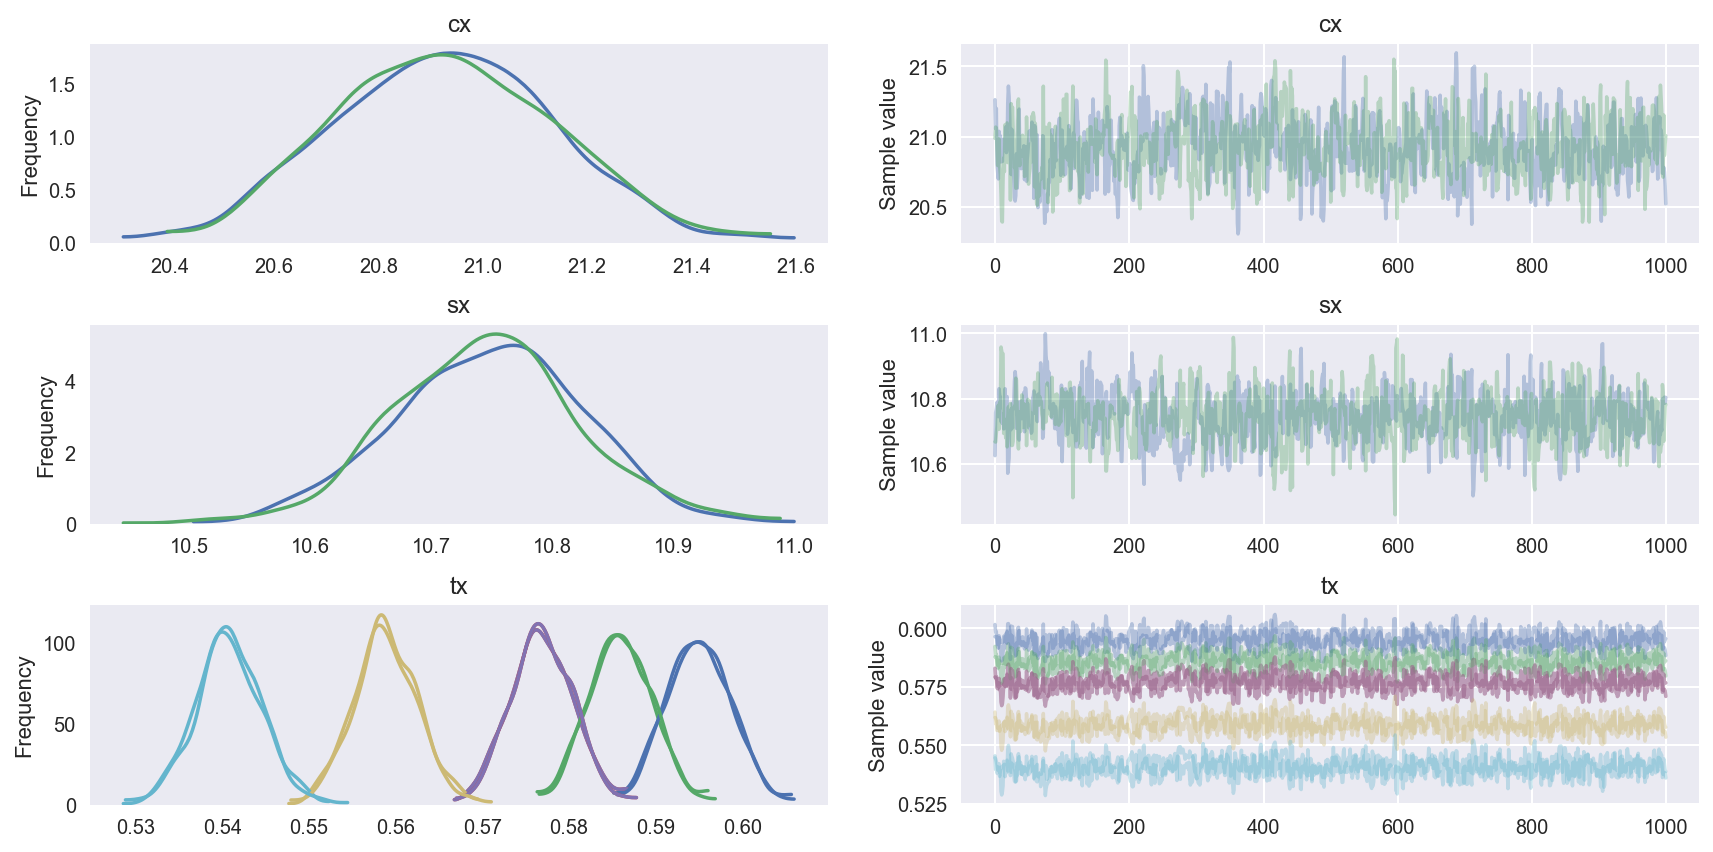

In [7]:
ymat = np.asarray(y).T
mmat = m.T
W = listlength

with pm.Model() as simple2:
    cx = pm.Uniform('cx', lower=0, upper=100, testval=21)
    sx = pm.Uniform('sx', lower=0, upper=100, testval=10)
    a1 = pm.Uniform('a1', lower=-1, upper=0, testval=-.002)
    a2 = pm.Uniform('a2', lower=0, upper=1, testval=.64)
    tx = pm.Deterministic('tx', a1 * W + a2)

    yobs = []
    for x in range(dsets):
        sz = listlength[x]
        # Similarities
        m1 = np.array([mmat[0:sz, x], ] * sz).T
        m2 = np.array([mmat[0:sz, x], ] * sz)

        eta = tt.exp(-cx * abs(tt.log(m1) - tt.log(m2)))
        etasum = tt.reshape(tt.repeat(tt.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + tt.exp(-sx * (disc - tx[x])))
        # Free Recall Overall Response Probability
        theta = tt.clip(tt.sum(resp, axis=1), 0, .999)
        # theta=1-tt.prod(1-resp,axis=1)

        yobs.append([pm.Binomial('yobs_%x' % x,
                                 p=theta, n=n[x], observed=ymat[0:sz, x])])

    trace2 = pm.sample(1000, tune=1000, init='advi+adapt_diag')

pm.traceplot(trace2, varnames=['cx', 'sx', 'tx']);

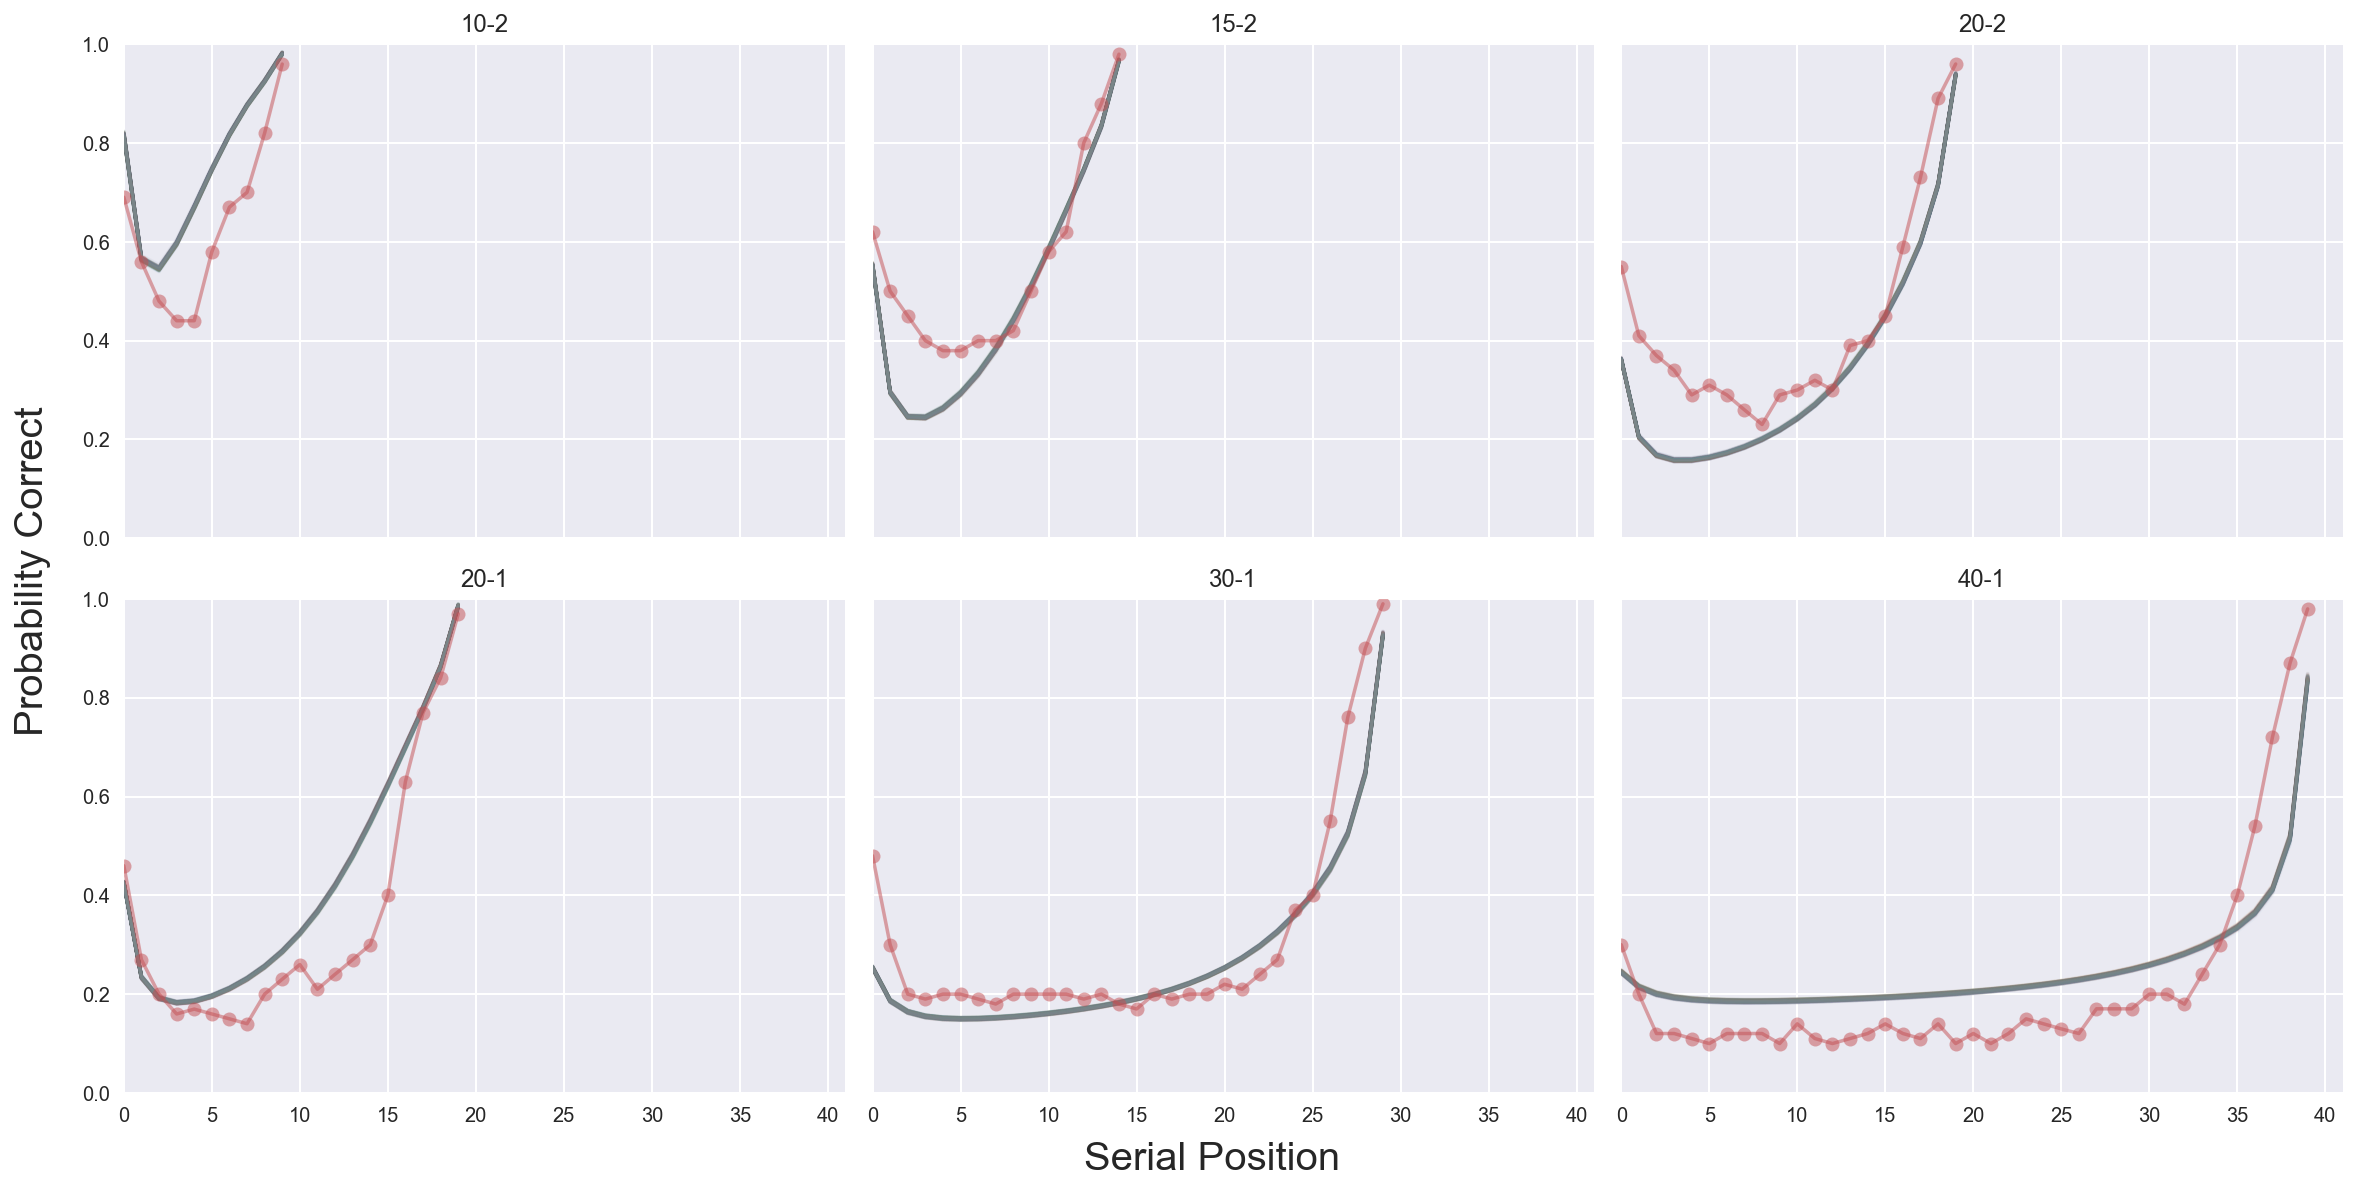

In [14]:
trace = trace2

ymat = np.asarray(y).T
mmat = m.T

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
gs = axes.flatten()
fig.text(0.5, -0.02, 'Serial Position', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Probability Correct',
         va='center', rotation='vertical', fontsize=20)

burnin = 0
totalsamp = 1000
ppcsamples = 200

for ip in range(dsets):
    ax = gs[ip]
    ay = ymat[:, ip] / n[ip]  # pcmat[:,ip]

    cxt = trace['cx']
    sxt = trace['sx']
    txt = trace['tx'][:, ip]

    sz = listlength[ip]
    # Similarities
    m1 = np.array([mmat[0:sz, ip], ] * sz).T
    m2 = np.array([mmat[0:sz, ip], ] * sz)
    for ips in np.random.randint(burnin, totalsamp, ppcsamples):

        eta = np.exp(-cxt[ips] * abs(np.log(m1) - np.log(m2)))
        etasum = np.reshape(np.repeat(np.sum(eta, axis=1), sz), (sz, sz))
        # Discriminabilities
        disc = eta / etasum
        # Response Probabilities
        resp = 1 / (1 + np.exp(-sxt[ips] * (disc - txt[ips])))
        # Free Recall Overall Response Probability
        theta = np.minimum(np.sum(resp, axis=1), .999)
        ax.plot(theta, alpha=.05)

    ax.plot(ay[ay != 0], marker='o', alpha=.5)
    ax.axis((0, 41, 0, 1))
    ax.set_title(str(listlength[ip]) + '-' + str(lagall[ip]))

plt.tight_layout()

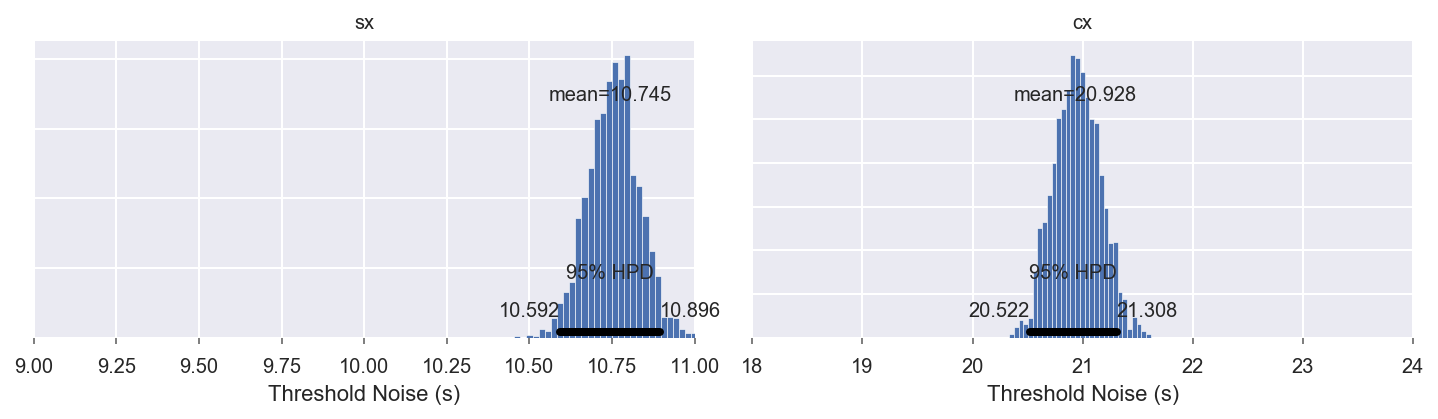

In [17]:
fig = plt.figure(figsize=(15, 3))
ax1 = plt.subplot(1, 3, 1)
pm.plot_posterior(trace=trace, varnames=['sx'], ax=ax1)
ax1.set_xlabel('Threshold Noise (s)')
ax1.set_xlim([9, 11])
ax2 = plt.subplot(1, 3, 2)
pm.plot_posterior(trace=trace, varnames=['cx'], ax=ax2)
ax2.set_xlabel('Threshold Noise (s)')
ax2.set_xlim([18, 24])
plt.tight_layout()